# **Convolutional Neural Network (CNN) Model for Car Image Identification**
In this project, I will develop, train, and test a car image classifier with PyTorch over the [stanford car dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html).

![](https://ai.stanford.edu/~jkrause/cars/class_montage.jpg)

# **Part 1: Data Loading and Preprocessing**

## 1.1 Mount google drive

In [ ]:
from google.colab import drive
import os

drive.mount('ggdrive')

Drive already mounted at ggdrive; to attempt to forcibly remount, call drive.mount("ggdrive", force_remount=True).


## 1.2 Unzip data to colab

In [ ]:
%%time
if not os.path.isdir('./stanford_car_dataset'):
  !mkdir ./stanford_car_dataset
  !unzip -q ./ggdrive/My\ Drive/dataSet/stanford_car_dataset.zip -d ./stanford_car_dataset

CPU times: user 31 µs, sys: 0 ns, total: 31 µs
Wall time: 73.4 µs


## 1.3 Read image types and numbers information

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%matplotlib inline

img_class_num = []
path = 'stanford_car_dataset/car_data/car_data'
groups = os.listdir(path)
for group in groups:
  path1 = f'{path}/{group}'
  cars = os.listdir(path1)
  for car in cars:
    path2 = f'{path1}/{car}'
    img_class_num += [[car, group, img] for img in os.listdir(path2)]

df_img = pd.DataFrame(data=img_class_num, columns=['car', 'group', 'img'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1.4 Data statistical information

### 1.4.1 Basic information

In [ ]:
df_img

,car,group,img
0,Audi RS 4 Convertible 2008,train,02885.jpg
1,Audi RS 4 Convertible 2008,train,07241.jpg
2,Audi RS 4 Convertible 2008,train,07307.jpg
3,Audi RS 4 Convertible 2008,train,08014.jpg
4,Audi RS 4 Convertible 2008,train,04818.jpg
...,...,...,...
16180,McLaren MP4-12C Coupe 2012,test,06659.jpg
16181,McLaren MP4-12C Coupe 2012,test,05251.jpg
16182,McLaren MP4-12C Coupe 2012,test,00547.jpg
16183,McLaren MP4-12C Coupe 2012,test,02186.jpg


### 1.4.2 Number of images (16185)

In [ ]:
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16185 entries, 0 to 16184
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   car     16185 non-null  object
 1   group   16185 non-null  object
 2   img     16185 non-null  object
dtypes: object(3)
memory usage: 379.5+ KB


### 1.4.3 Nunique

In [ ]:
df_img.describe()

,car,group,img
count,16185,16185,16185
unique,196,2,8144
top,GMC Savana Van 2012,train,00825.jpg
freq,136,8144,2


### 1.4.4 Percentage between train and test for each class

In [ ]:
df_img_stat = df_img.groupby(['car', 'group'])['img'].agg(['count']).reset_index()
df_img_stat['count %'] = df_img_stat.groupby('car')['count'].transform(lambda x: x / sum(x))
df_img_stat

,car,group,count,count %
0,AM General Hummer SUV 2000,test,44,0.494382
1,AM General Hummer SUV 2000,train,45,0.505618
2,Acura Integra Type R 2001,test,44,0.494382
3,Acura Integra Type R 2001,train,45,0.505618
4,Acura RL Sedan 2012,test,32,0.500000
...,...,...,...,...
387,Volvo C30 Hatchback 2012,train,42,0.506024
388,Volvo XC90 SUV 2007,test,43,0.500000
389,Volvo XC90 SUV 2007,train,43,0.500000
390,smart fortwo Convertible 2012,test,40,0.500000


### 1.4.5 Visualization of number of images for each class

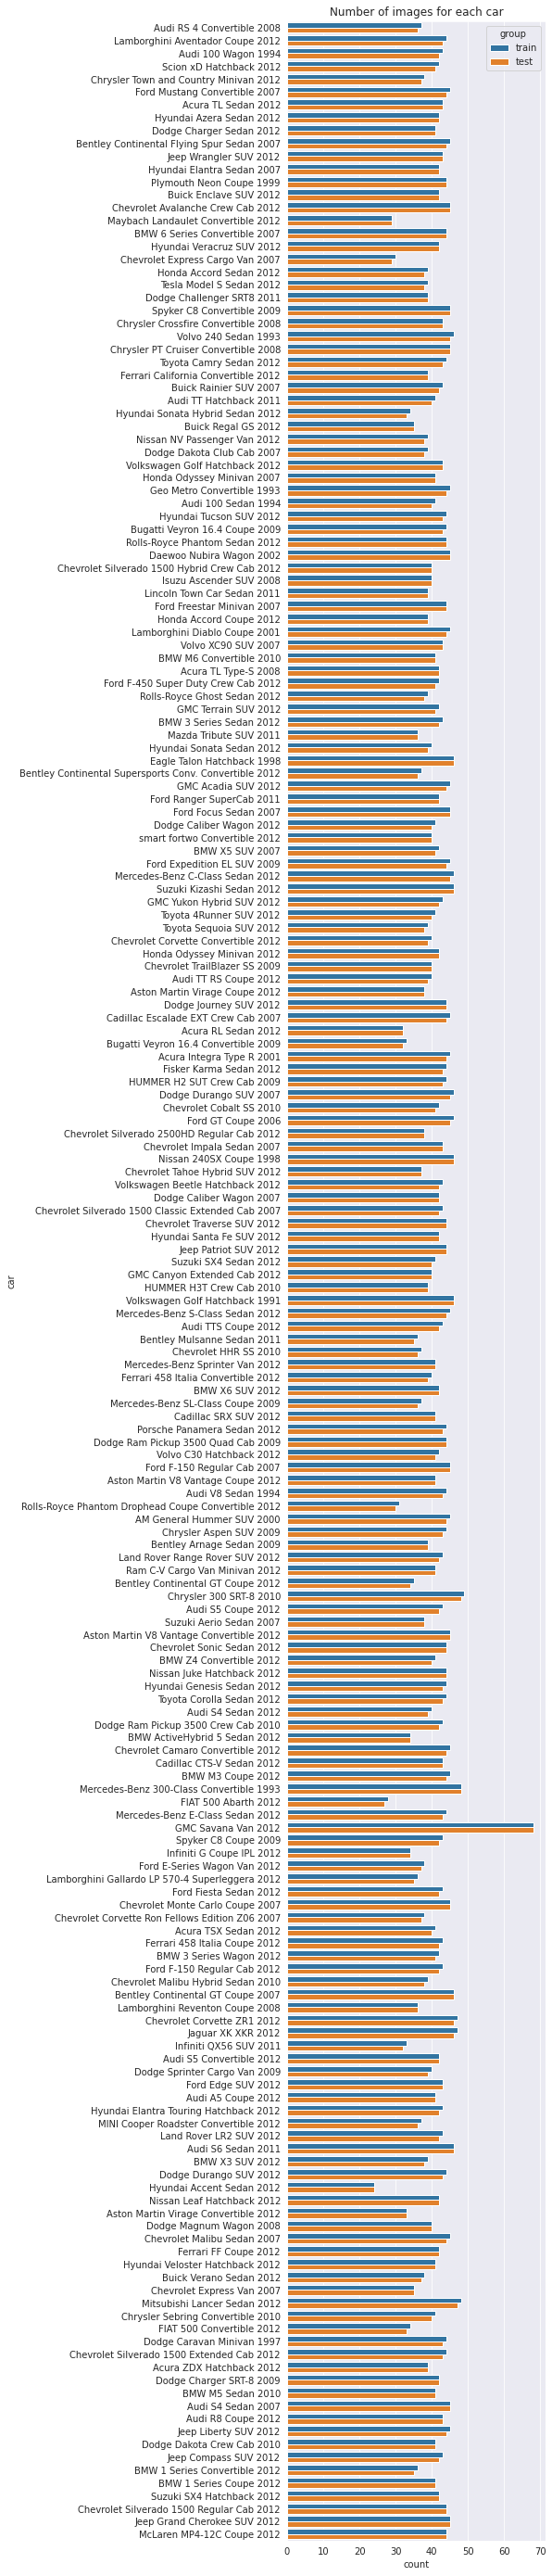

In [ ]:
fig = plt.figure(figsize=[5, 50])
ax = sns.countplot(y='car', hue='group', data=df_img)
ax.set_title('Number of images for each car')
plt.show()

## 1.5 Data load and transformation
Transformations / data augmentations:
- 224 x 224 resolution
- Random horizontal flip
- Random rotation
- normalization

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

def dataloader(dataset_path, image_size=224, batchSZ=32):
  width, height = image_size, image_size

  train_tfms = transforms.Compose([transforms.Resize((width, height)),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.RandomRotation(15),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
  test_tfms = transforms.Compose([transforms.Resize((width, height)),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

  # create datasets
  datasetTrain = torchvision.datasets.ImageFolder(root=dataset_path + "train", transform=train_tfms)
  trainloader = torch.utils.data.DataLoader(datasetTrain, batch_size=batchSZ, shuffle=True, num_workers=2)

  datasetTest = torchvision.datasets.ImageFolder(root=dataset_path + "test", transform = test_tfms)
  testloader = torch.utils.data.DataLoader(datasetTest, batch_size=batchSZ, shuffle=False, num_workers=2)
  
  return trainloader, testloader

# **Part 2: Build models**

## 2.0 Packages and device

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import time
#import PIL.Image as Image
#from IPython.display import display

if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device('cpu')
print(f'{device} @ {torch.cuda.get_device_name(device)}')

cuda:0 @ Tesla P100-PCIE-16GB


## 2.1 Helper function for freezing autograd

In [ ]:
def freeze_grad(model, freeze):  
  if freeze: # if True, freeze autograd, aim to only extract image features
    for param in model.parameters():
      param.requires_grad = False

## 2.2 Initialize and modify pre-trained models
It is difficult to directly train deep learning model on this dataset because the limited number of images. Here we decide to use transfer learning, a common approch used in deep learning, to utilize the pretrained model on [imagenet](http://www.image-net.org/) and fine-tune over our car image dataset.

In [ ]:
import torchvision.models as models

def pretrained_model(model_name, freeze=False, num_classes=196):

  model_ft = None
  image_size = 224

  if model_name == "alexnet": 
    # initialize model
    model_ft = models.alexnet(pretrained=True)
    # freeze grad updates depends on freeze
    freeze_grad(model_ft, freeze)
    # reshape the last fc layer
    # print(model_ft) is useful
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)

  elif model_name == "resnet34":
    model_ft = models.resnet34(pretrained=True)
    freeze_grad(model_ft, freeze)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)

  elif model_name == "resnet50":
    model_ft = models.resnet50(pretrained=True)
    freeze_grad(model_ft, freeze)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
  
  elif model_name == "inceptionV3":
    model_ft = models.inception_v3(pretrained=True)
    freeze_grad(model_ft, freeze)
    # auxilary output layer
    num_ftrs = model_ft.AuxLogits.fc.in_features
    model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
    # primary output layer
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    image_size = 299

  else:
    print("Invalid model name, exiting...")
    exit()
  
  return model_ft, image_size

## 2.3 Cross Entropy Loss

In [ ]:
criterion = nn.CrossEntropyLoss()

## 2.4 Optimizer and lr_scheduler

In [ ]:
def my_optim(model_ft):
  params_to_update = []
  for name, param in model_ft.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
      # print("\t", name)
  
  optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)

  """
  probably not the best metric to track, but we are tracking the training accuracy and measuring whether
  it increases by atleast 0.9 per epoch and if it hasn't increased by 0.9 reduce the lr by 0.1x.
  However in this model it did not benefit me.
  """
  lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
  
  return optimizer, lrscheduler

## 2.5 Model training function

Here we train our model, after each epoch, we test the model on the test data to see how it's going

In [ ]:
import copy

def train_model(model, trainloader, testloader, criterion, optimizer, \
                scheduler, n_epochs=15, batchSZ=32, is_inception=False):
    
    train_loss = []
    train_accu = []
    test_accu = []

    # save the last best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accu= 0.0

    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        epoch_loss = 0.0
        epoch_accu = 0.0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data
            #inputs = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            if is_inception:
              outputs, aux_outputs = model(inputs)
              loss1 = criterion(outputs, labels)
              loss2 = criterion(aux_outputs, labels)
              loss = loss1 + 0.4 * loss2
            else:
              outputs = model(inputs)
              loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acculater
            epoch_loss += loss.item()
            epoch_accu += (labels==predicted).sum().item()

        epoch_duration = time.time() - since
        epoch_loss = epoch_loss / len(trainloader)
        epoch_accu = 100 * epoch_accu / batchSZ / len(trainloader)
        print("Epoch %d:\n\ttraining:  spent %5.1f secs --- accuracy %5.2f%% --- loss %.4f" % (epoch+1, epoch_duration, epoch_accu, epoch_loss))
        
        train_loss.append(epoch_loss)
        train_accu.append(epoch_accu)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model, testloader)#, is_inception)
        test_accu.append(test_acc)
        
        #update best model
        if test_acc > best_accu:
          best_accu = test_acc
          best_model_wts = copy.deepcopy(model.state_dict())

        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
    print('------- Finished Training -------\nBest testing accuracy: ', best_accu)
    model.load_state_dict(best_model_wts)
    return model, train_loss, train_accu, test_accu

## 2.6 Evaluation function

In [ ]:
def eval_model(model, testloader):  #, is_inception):
    since = time.time()
    test_accu = 0.0
    num_image = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            #images = images.to(device).half() # uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            num_image += labels.size(0)
            test_accu += (predicted == labels).sum().item()

    test_accu = 100.0 * test_accu / num_image
    duration = time.time() - since
    print('\t testing:  spent %5.1f secs --- accuracy %5.2f%%' % (duration, test_accu))
    return test_accu

## 2.7 Visualize training history

In [ ]:
def visuHist(model_nm, train_loss, train_accu, test_accu):
  fig = plt.figure(figsize=(15, 5))

  ax1 = fig.add_axes([0.1, 0.61, 0.8, 0.3], xticklabels=[])
  ax1.plot(train_loss, 'b-o', label="training_loss")
  ax1.legend(loc=3)
  ax1.set_ylabel("cross entropy loss")

  ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.49], ylim=[0, 100])
  ax2.plot(train_accu, 'b-o', label="training_accuracy")
  ax2.plot(test_accu, 'r-o', label="testing_accuracy")
  ax2.legend(loc=2)
  ax2.set_ylabel("accuracy")
  ax2V = ax2.get_yticks()
  ax2.set_yticklabels(['{:.1%}'.format(x/100) for x in ax2V])
  ax2.set_xlabel("epoch")

  ax1.set_title(model_nm, fontsize=16)
  plt.show()

# Part 3: Train models and check their performances

## 3.1 Parameters Space

In [ ]:
model_names = ['alexnet', 'resnet34', 'resnet50', 'inceptionV3']
freezes = [False, True]

dataset_path = "./stanford_car_dataset/car_data/car_data/"
num_classes = 196
cur_image_size = 0
batchSZ = 32

### A smaller param space, ONLY for debugging

In [ ]:
if False:
  model_names = ['alexnet']
  freezes = [False]

## 3.2 Training models


====== alexnet_aug_fineturning ======

Epoch 1:
	training:  spent  88.5 secs --- accuracy  0.51% --- loss 5.2908
	 testing:  spent  82.7 secs --- accuracy  0.80%
Epoch 2:
	training:  spent  86.3 secs --- accuracy  0.74% --- loss 5.2802
	 testing:  spent  81.9 secs --- accuracy  0.91%
Epoch 3:
	training:  spent  85.7 secs --- accuracy  0.82% --- loss 5.2739
	 testing:  spent  80.8 secs --- accuracy  0.85%
Epoch 4:
	training:  spent  83.1 secs --- accuracy  0.88% --- loss 5.2648
	 testing:  spent  78.5 secs --- accuracy  0.76%
Epoch 5:
	training:  spent  85.0 secs --- accuracy  1.15% --- loss 5.2463
	 testing:  spent  85.9 secs --- accuracy  1.44%
Epoch 6:
	training:  spent  86.2 secs --- accuracy  1.45% --- loss 5.1588
	 testing:  spent  81.1 secs --- accuracy  1.64%
Epoch 7:
	training:  spent  83.3 secs --- accuracy  1.91% --- loss 5.0844
	 testing:  spent  78.6 secs --- accuracy  2.59%
Epoch 8:
	training:  spent  83.4 secs --- accuracy  3.00% --- loss 4.9864
	 testing:  spent  79.0 s

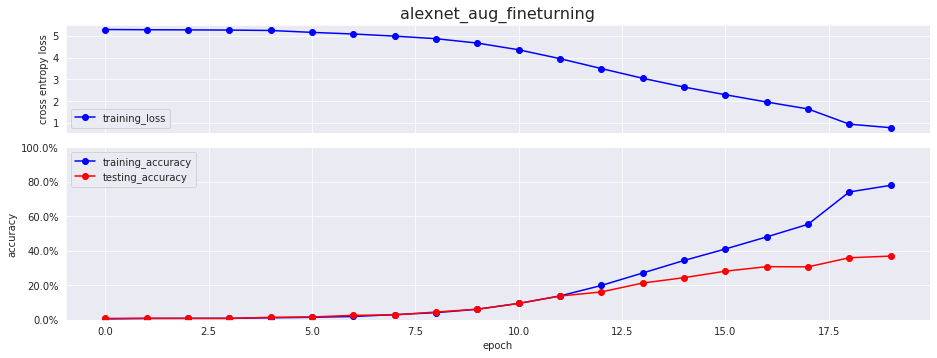

total time:   3300.9 secs

====== alexnet_aug_featureExtracting ======

Epoch 1:
	training:  spent  81.8 secs --- accuracy  6.91% --- loss 7.7572
	 testing:  spent  78.9 secs --- accuracy  9.27%
Epoch 2:
	training:  spent  84.8 secs --- accuracy 14.94% --- loss 7.3379
	 testing:  spent  79.7 secs --- accuracy 11.90%
Epoch 3:
	training:  spent  82.9 secs --- accuracy 19.66% --- loss 6.6708
	 testing:  spent  79.4 secs --- accuracy 11.53%
Epoch 4:
	training:  spent  81.8 secs --- accuracy 23.63% --- loss 6.3653
	 testing:  spent  80.5 secs --- accuracy 13.03%
Epoch 5:
	training:  spent  83.6 secs --- accuracy 27.54% --- loss 5.9494
	 testing:  spent  81.0 secs --- accuracy 13.73%
Epoch 6:
	training:  spent  84.4 secs --- accuracy 42.86% --- loss 3.4414
	 testing:  spent  81.6 secs --- accuracy 18.14%
Epoch 7:
	training:  spent  85.2 secs --- accuracy 47.41% --- loss 2.6936
	 testing:  spent  81.5 secs --- accuracy 19.24%
Epoch 8:
	training:  spent  83.2 secs --- accuracy 50.13% --- loss 

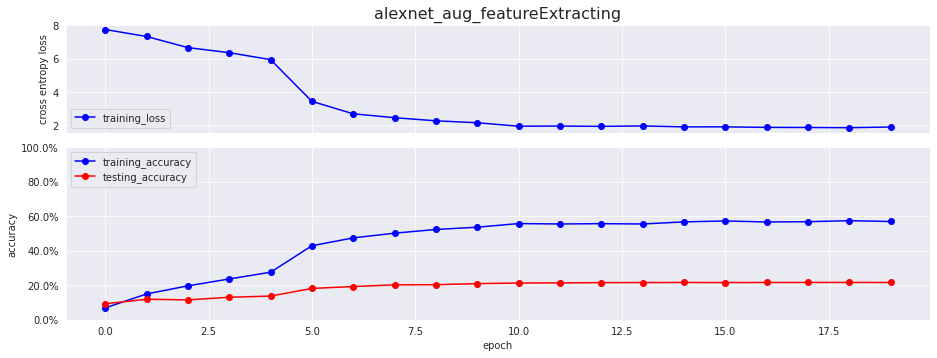

total time:   3346.6 secs

====== resnet34_aug_fineturning ======



Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



Epoch 1:
	training:  spent  88.8 secs --- accuracy 15.00% --- loss 3.9366
	 testing:  spent  80.1 secs --- accuracy 25.71%
Epoch 2:
	training:  spent  88.0 secs --- accuracy 46.30% --- loss 1.9808
	 testing:  spent  79.1 secs --- accuracy 40.78%
Epoch 3:
	training:  spent  87.4 secs --- accuracy 64.58% --- loss 1.2521
	 testing:  spent  79.8 secs --- accuracy 54.92%
Epoch 4:
	training:  spent  89.6 secs --- accuracy 73.63% --- loss 0.8859
	 testing:  spent  78.9 secs --- accuracy 58.65%
Epoch 5:
	training:  spent  87.4 secs --- accuracy 79.41% --- loss 0.6839
	 testing:  spent  78.7 secs --- accuracy 66.02%
Epoch 6:
	training:  spent  87.6 secs --- accuracy 84.61% --- loss 0.4927
	 testing:  spent  79.1 secs --- accuracy 65.48%
Epoch 7:
	training:  spent  86.7 secs --- accuracy 89.06% --- loss 0.3637
	 testing:  spent  78.9 secs --- accuracy 71.31%
Epoch 8:
	training:  spent  85.6 secs --- accuracy 95.15% --- loss 0.1631
	 testing:  spent  77.9 secs --- accuracy 82.88%
Epoch 9:
	train

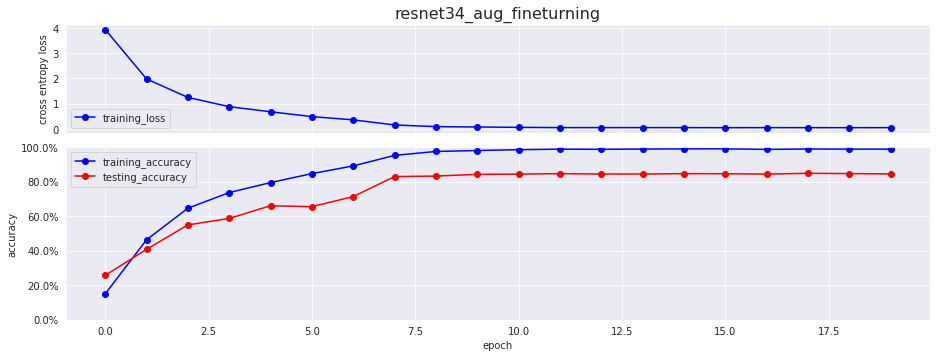

total time:   3369.2 secs

====== resnet34_aug_featureExtracting ======

Epoch 1:
	training:  spent  83.6 secs --- accuracy  5.93% --- loss 4.9248
	 testing:  spent  79.6 secs --- accuracy 12.29%
Epoch 2:
	training:  spent  82.0 secs --- accuracy 18.93% --- loss 3.7657
	 testing:  spent  79.1 secs --- accuracy 18.58%
Epoch 3:
	training:  spent  83.0 secs --- accuracy 28.65% --- loss 3.1866
	 testing:  spent  80.0 secs --- accuracy 23.13%
Epoch 4:
	training:  spent  82.7 secs --- accuracy 34.68% --- loss 2.8191
	 testing:  spent  79.9 secs --- accuracy 23.70%
Epoch 5:
	training:  spent  83.2 secs --- accuracy 38.31% --- loss 2.6111
	 testing:  spent  80.9 secs --- accuracy 26.22%
Epoch 6:
	training:  spent  82.8 secs --- accuracy 42.79% --- loss 2.4011
	 testing:  spent  79.5 secs --- accuracy 29.19%
Epoch 7:
	training:  spent  81.2 secs --- accuracy 45.29% --- loss 2.2778
	 testing:  spent  80.2 secs --- accuracy 28.73%
Epoch 8:
	training:  spent  83.4 secs --- accuracy 47.52% --- loss

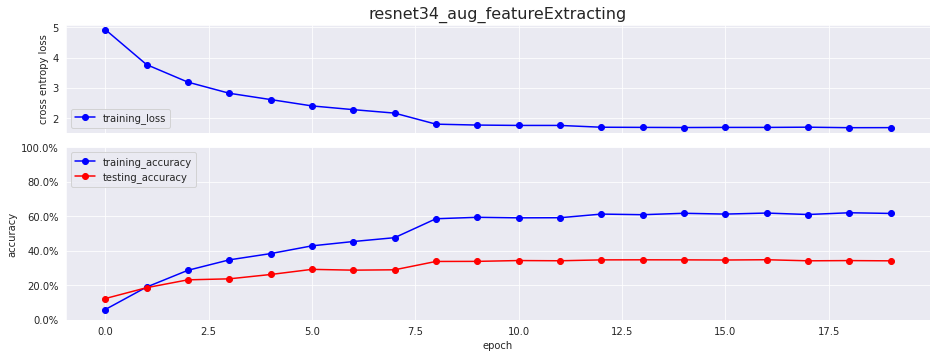

total time:   3274.8 secs

====== resnet50_aug_fineturning ======



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Epoch 1:
	training:  spent  94.5 secs --- accuracy 16.19% --- loss 3.8397
	 testing:  spent  81.7 secs --- accuracy 34.47%
Epoch 2:
	training:  spent  93.5 secs --- accuracy 48.35% --- loss 1.9178
	 testing:  spent  79.5 secs --- accuracy 48.75%
Epoch 3:
	training:  spent  94.6 secs --- accuracy 64.19% --- loss 1.2367
	 testing:  spent  81.7 secs --- accuracy 55.88%
Epoch 4:
	training:  spent  95.1 secs --- accuracy 72.78% --- loss 0.9069
	 testing:  spent  82.7 secs --- accuracy 56.61%
Epoch 5:
	training:  spent  94.8 secs --- accuracy 78.91% --- loss 0.6926
	 testing:  spent  81.1 secs --- accuracy 66.19%
Epoch 6:
	training:  spent  93.3 secs --- accuracy 83.46% --- loss 0.5281
	 testing:  spent  80.4 secs --- accuracy 70.23%
Epoch 7:
	training:  spent  93.5 secs --- accuracy 88.15% --- loss 0.3914
	 testing:  spent  80.2 secs --- accuracy 72.40%
Epoch 8:
	training:  spent  92.2 secs --- accuracy 89.75% --- loss 0.3309
	 testing:  spent  80.5 secs --- accuracy 73.88%
Epoch 9:
	train

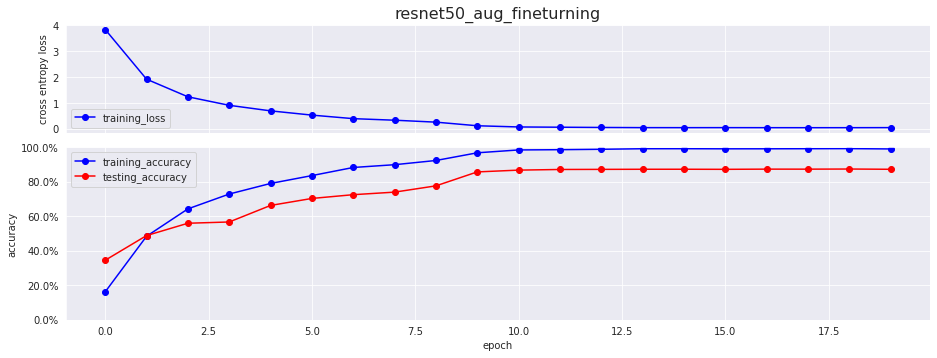

total time:   3539.7 secs

====== resnet50_aug_featureExtracting ======

Epoch 1:
	training:  spent  86.5 secs --- accuracy  4.78% --- loss 5.0185
	 testing:  spent  82.7 secs --- accuracy 11.07%
Epoch 2:
	training:  spent  85.5 secs --- accuracy 17.29% --- loss 3.9613
	 testing:  spent  82.0 secs --- accuracy 16.65%
Epoch 3:
	training:  spent  86.5 secs --- accuracy 25.82% --- loss 3.4130
	 testing:  spent  84.9 secs --- accuracy 20.99%
Epoch 4:
	training:  spent  86.7 secs --- accuracy 31.59% --- loss 3.0472
	 testing:  spent  83.0 secs --- accuracy 25.88%
Epoch 5:
	training:  spent  85.7 secs --- accuracy 35.85% --- loss 2.7945
	 testing:  spent  82.9 secs --- accuracy 25.47%
Epoch 6:
	training:  spent  85.4 secs --- accuracy 40.26% --- loss 2.5802
	 testing:  spent  81.2 secs --- accuracy 28.09%
Epoch 7:
	training:  spent  84.4 secs --- accuracy 42.37% --- loss 2.4578
	 testing:  spent  81.3 secs --- accuracy 27.55%
Epoch 8:
	training:  spent  82.2 secs --- accuracy 45.75% --- loss

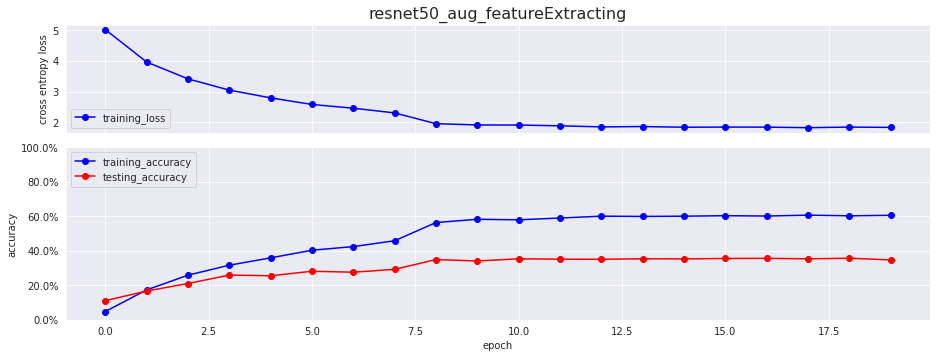

total time:   3361.6 secs

====== inceptionV3_aug_fineturning ======



Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



Epoch 1:
	training:  spent 115.1 secs --- accuracy 10.53% --- loss 5.7921
	 testing:  spent  94.9 secs --- accuracy 21.83%
Epoch 2:
	training:  spent 115.3 secs --- accuracy 43.90% --- loss 2.8711
	 testing:  spent  93.6 secs --- accuracy 54.06%
Epoch 3:
	training:  spent 111.9 secs --- accuracy 67.92% --- loss 1.5704
	 testing:  spent  91.7 secs --- accuracy 68.86%
Epoch 4:
	training:  spent 112.1 secs --- accuracy 79.13% --- loss 0.9857
	 testing:  spent  91.5 secs --- accuracy 77.29%
Epoch 5:
	training:  spent 109.7 secs --- accuracy 86.27% --- loss 0.6519
	 testing:  spent  89.1 secs --- accuracy 79.53%
Epoch 6:
	training:  spent 109.5 secs --- accuracy 89.24% --- loss 0.4748
	 testing:  spent  90.7 secs --- accuracy 81.03%
Epoch 7:
	training:  spent 109.9 secs --- accuracy 95.31% --- loss 0.2396
	 testing:  spent  91.1 secs --- accuracy 88.41%
Epoch 8:
	training:  spent 110.8 secs --- accuracy 96.96% --- loss 0.1643
	 testing:  spent  91.3 secs --- accuracy 89.33%
Epoch 9:
	train

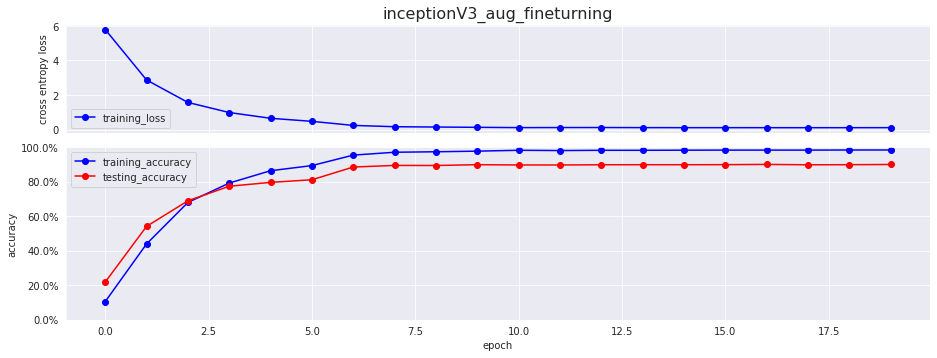

total time:   4081.1 secs

====== inceptionV3_aug_featureExtracting ======

Epoch 1:
	training:  spent  94.2 secs --- accuracy  2.50% --- loss 7.1011
	 testing:  spent  92.9 secs --- accuracy  7.36%
Epoch 2:
	training:  spent  98.4 secs --- accuracy  8.82% --- loss 6.0982
	 testing:  spent  93.7 secs --- accuracy 13.00%
Epoch 3:
	training:  spent  96.1 secs --- accuracy 14.91% --- loss 5.4661
	 testing:  spent  91.0 secs --- accuracy 16.98%
Epoch 4:
	training:  spent  93.7 secs --- accuracy 19.14% --- loss 5.0311
	 testing:  spent  89.1 secs --- accuracy 18.19%
Epoch 5:
	training:  spent  93.5 secs --- accuracy 23.16% --- loss 4.6690
	 testing:  spent  90.8 secs --- accuracy 20.88%
Epoch 6:
	training:  spent  98.1 secs --- accuracy 26.18% --- loss 4.4412
	 testing:  spent  90.2 secs --- accuracy 20.63%
Epoch 7:
	training:  spent  94.1 secs --- accuracy 27.95% --- loss 4.2230
	 testing:  spent  89.1 secs --- accuracy 22.40%
Epoch 8:
	training:  spent  94.7 secs --- accuracy 33.79% --- l

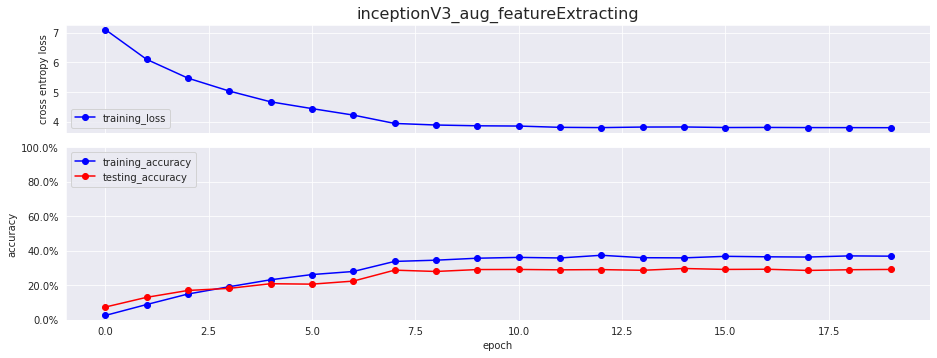

total time:   3684.2 secs


In [ ]:
trained_models = {}
RETRAIN = True

for model_name in model_names:
  for freeze in freezes:
    t0 = time.time()

    trained_model_name = model_name + '_aug' + ('_featureExtracting' if freeze else '_fineturning')
    print(f"\n====== {trained_model_name} ======\n")
    model_ft, image_size = pretrained_model(model_name, freeze, num_classes)
    
    if cur_image_size != image_size:
      trainloader, testloader = dataloader(dataset_path, image_size, batchSZ)
      cur_image_size = image_size
    
    model_ft = model_ft.to(device)
    # uncomment this block for half precision model
    """
    model_ft = model_ft.half()

    for layer in model_ft.modules():
      if isinstance(layer, nn.BatchNorm2d):
        layer.float()
    """
    optimizer, lrscheduler = my_optim(model_ft)
    
    file_path = f'ggdrive/My Drive/Projects/old/CNN_models/{trained_model_name}.pth'
    if RETRAIN:
      is_inception = True if model_name == "inceptionV3" else False
      model, train_loss, train_accu, test_accu = train_model(model_ft, \
                      trainloader, testloader, criterion, optimizer, \
                      lrscheduler, n_epochs=20, batchSZ=batchSZ, is_inception=is_inception)
    
      visuHist(trained_model_name, train_loss, train_accu, test_accu)
      torch.save(model.state_dict(), file_path)     
      trained_models[trained_model_name] = (model, image_size)
    else:
      model_ft.load_state_dict(torch.load(file_path))
      trained_models[trained_model_name] = (model_ft, image_size)


    print("total time: %8.1f secs" % (time.time() - t0))

## 3.3 Check models performance
We should apply our trained models to predict the classes of unseen images to check their power. Here I just show how they perform on randomly pick up testing images.

### 3.3.1 Car - label conversion dictionary

In [ ]:
def class_label(testdata_path):
    classes = os.listdir(testdata_path)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
    
classes, class_to_idx = class_label(dataset_path+"test")

### 3.3.2 Randomly pick up batchSZ testing images

In [ ]:
def testImages(dataset_path, batchSZ=4, image_size=299):
  width, height = image_size, image_size

  test_tfms = transforms.Compose([transforms.Resize((width, height)),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

  dataset = torchvision.datasets.ImageFolder(root=dataset_path+"test", transform = test_tfms)
  testloader = torch.utils.data.DataLoader(dataset, batch_size=batchSZ, shuffle=True, num_workers=2)
  
  return testloader

### 3.3.3 Visualize pickuped images

In [ ]:
sns.set_style('dark')
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    #plt.imshow(inp)
    plt.figure(figsize = (15,15))
    plt.imshow(inp, interpolation='nearest')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

### 3.3.4 Models prediction over these images

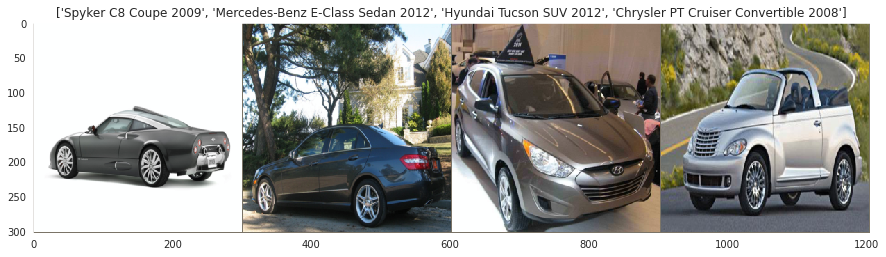

======================================== alexnet_aug_fineturning ========================================
                                  label  ... correct prediction?
0                  Spyker C8 Coupe 2009  ...               False
1      Mercedes-Benz E-Class Sedan 2012  ...               False
2               Hyundai Tucson SUV 2012  ...               False
3  Chrysler PT Cruiser Convertible 2008  ...                True

[4 rows x 3 columns]
======================================== alexnet_aug_featureExtracting ========================================
                                  label  ... correct prediction?
0                  Spyker C8 Coupe 2009  ...               False
1      Mercedes-Benz E-Class Sedan 2012  ...               False
2               Hyundai Tucson SUV 2012  ...               False
3  Chrysler PT Cruiser Convertible 2008  ...                True

[4 rows x 3 columns]
======================================== resnet34_aug_fineturning ======================

In [ ]:
batchSZ = 4
testImags = testImages(dataset_path, batchSZ)

# Get a batch of training data
imags, labls = next(iter(testImags))
car_nms = [classes[x] for x in labls]

# Make a grid from batch
out = torchvision.utils.make_grid(imags)
imshow(out, title=car_nms)

imags = imags.to(device)
pd.set_option('display.width', 300)
for model_nm in trained_models:
  model, image_size = trained_models[model_nm]
  model = model.to(device)
  model.eval()
  output = model(imags)
  _, predict = torch.max(output, 1)
  print(f'{"="*40} {model_nm} {"="*40}')
  df_pred = pd.DataFrame(data = {'label': car_nms,
                                 'pred': [classes[x] for x in predict],
                                 'correct prediction?': (labls == predict.cpu())})
  print(df_pred)

## 3.4 Unmount google drive

In [ ]:
#drive.flush_and_unmount()